In [50]:
import re
from shapely import geometry
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from shapely.geometry.base import BaseGeometry


class MujocoObject:
    """placeholder until the real thing is implemented"""
    
    def __init__(self, name, mjcf_object):
        self.name = name
        self.mjcf_object = mjcf_object
    
    
    
class Rule(ABC):
    """Abstract class for rules."""
    
    @abstractmethod
    def __call__(self, map2d: dict, shape: BaseGeometry):
        pass

class MinDistanceRule(Rule):
    """Check if a new object respects the minimum distance to other objects of a specified type"""
    
    def __init__(self, dist: float, types: list([str,...]) = []):
        '''
        Initialize a new MinDistanceRule.
            Parameters:
                dist float(): minimal distance from the new object to all existing of specified type
                types list([str,...]): By default all objects in the environment will be considered. Alternatively a list with names can be passed and all mjcf-objects that include any of these names are considered, only. Can be regex.
        '''
        self.dist = dist
        self.types = types
        
        
    def __call__(self, map2d: dict, shape: BaseGeometry):
        '''
        Check if a new object satisfies the rule.
            Parameters:
                map_2d {name: BaseGeometry, ...}: dictionary, mapping names of objects to their shapely 2d representation
                shape BaseGeometry: insertion that should be evaluated
            Returns:
                True if shape is far enough away from each object that has any of self.types in their name.
        '''
        for obj in map2d:
            matches = [re.search(pattern, obj) for pattern in self.types]
            if any(matches) or not matches:                
                if shape.distance(map2d[obj]) < self.dist:
                    return False
        return True
        

class Validator:
    """class for maintaining a 2D representation for validation purposes, could be static"""
    
    def __init__(self, rules: list([Rule,...]) = []):
        '''
        Initialize new Validator.
            Parameters:
                rules list([Rule,...]): list of Rule objects. Each time that a new object is validated, all Rules have to be satisfied in order for the validation to return True
        '''
        self.map_2d = {} # {str: Geometry, ...} with str being the uniquely identifying mjcf name
        self.rules = []

    
    def validate(self, obj: MujocoObject):
        '''
        If all rules are satisfied, the new object will be included in the 2d representation and True is returned
            Parameters:
                obj MujocoObject: the new object, that will be evaluated
            Returns:
                True if the new object satirsfies all rules
        '''            
            
        # note: not sure if the mjcf structure will be consistent all the time...
        shape = geometry.Point(obj.mjcf_object.worldbody.body[0].pos[:2])
        for rule in self.rules:
            if not rule(self.map_2d, shape):
                return False
        
        self.map_2d.update({obj.name: shape})
        return True

    def plot(self):
        """Plot the current 2d representation to where ever the current mpl backend points."""
        for shape in self.map_2d.values():
            try:
                plt.plot(*shape.exterior.xy)
            except AttributeError:
                plt.scatter(*shape.xy)
        plt.show()

# Example 1
The two points happen to both have the coordinate (0.0, 0.0) so validating the second point returns false. After we shift the second object, the respective point will be inluded in the 2d representation and True is returned.

True


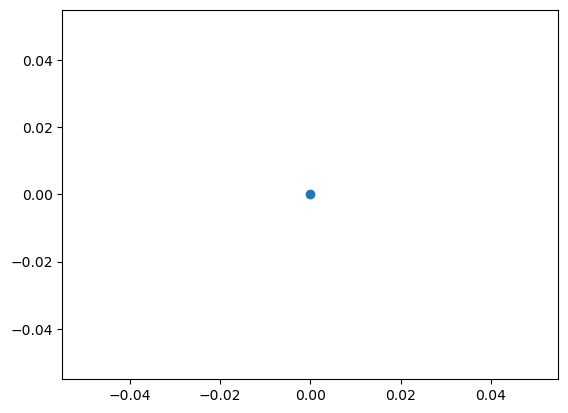

False


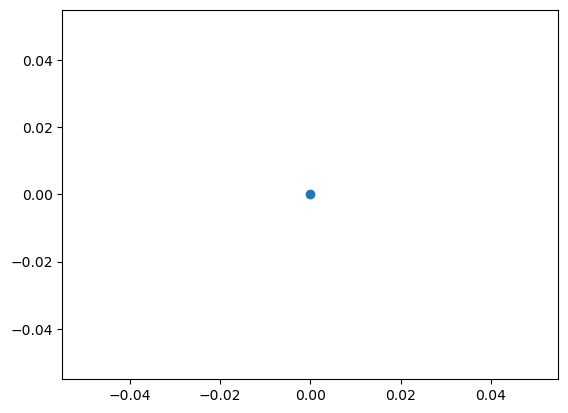

True


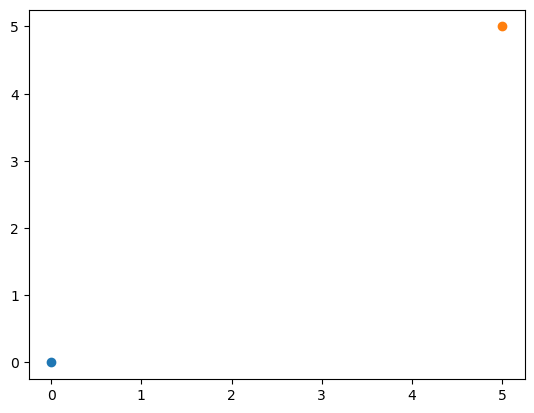

In [51]:
from parser import Parser

parser = Parser(xml_dir="../../examples/xml_objects")
mjcf1, mjcf2 = parser.get_mjcfs()

# for now we only consider placeholder objects
mjco1, mjco2 = MujocoObject("fire_ant", mjcf1), MujocoObject("human", mjcf2)

validator = Validator()
validator.rules.append(MinDistanceRule(5.0))

print(validator.validate(mjco1))
validator.plot()
print(validator.validate(mjco2))
validator.plot()

mjcf2.worldbody.body[0].pos[:2] = (5,5)
mjco2 = MujocoObject("human", mjcf2)
print(validator.validate(mjco2))
validator.plot()
plt.show()

# Example 2
The two points happen to both have the coordinate (0.0, 0.0). The validator was initialized with a rule, that only considers the distance to "tree"-objects, so no conflict is happening and both objects are initialized over each other. It will probably make sense, to always include a "no-collision" min-distance-rule that compares all objects.

True


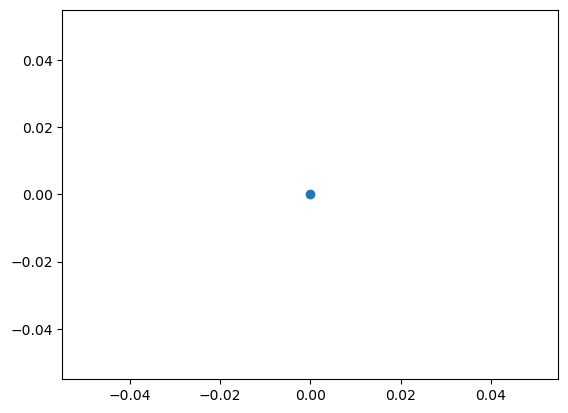

True


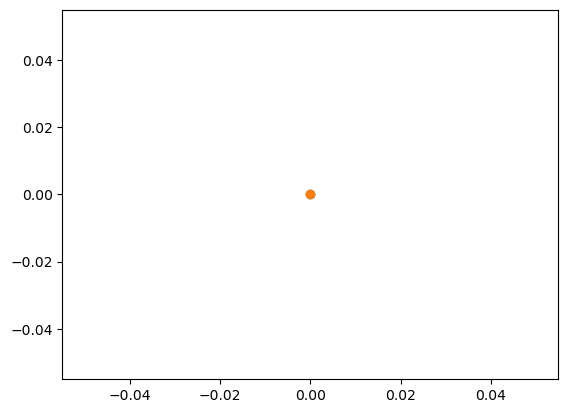

In [52]:
from parser import Parser
#from validator import Validator, MinDistanceRule, MujocoObject

parser = Parser(xml_dir="../../examples/xml_objects")
mjcf1, mjcf2 = parser.get_mjcfs()

# for now we only consider placeholder objects
mjco1, mjco2 = MujocoObject("fire_ant", mjcf1), MujocoObject("human", mjcf2)

validator = Validator()
validator.rules.append(MinDistanceRule(5.0, types=["tree"]))

print(validator.validate(mjco1))
validator.plot()
print(validator.validate(mjco2))
validator.plot()

# Example 3
The two points happen to both have the coordinate (0.0, 0.0). The validator was initialized with a rule, that only considers the distance to "ant"-objects. The first object is a fire-ant, which is considered a type of ant (the string "ant" is included, use regex like r"\Aant\b", if only "pure" ants should be consiered).

Evaluation result: True


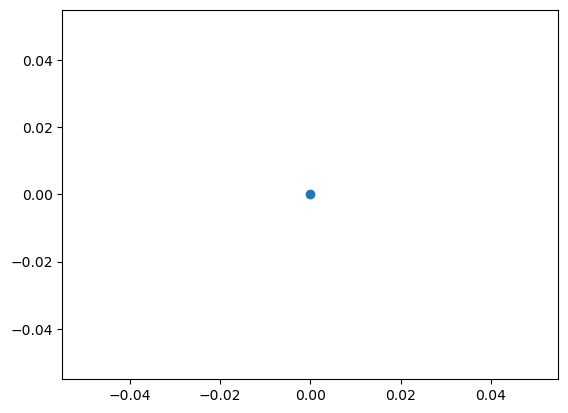

Evaluation result: False


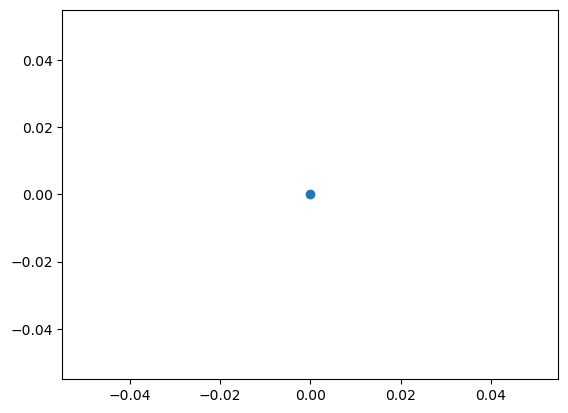

In [55]:
from parser import Parser
#from validator import Validator, MinDistanceRule, MujocoObject

parser = Parser(xml_dir="../../examples/xml_objects")
mjcf1, mjcf2 = parser.get_mjcfs()

# for now we only consider placeholder objects
mjco1, mjco2 = MujocoObject("fire_ant", mjcf1), MujocoObject("human", mjcf2)

validator = Validator()
validator.rules.append(MinDistanceRule(5.0, types=["ant"]))

print("Evaluation result:", validator.validate(mjco1))
validator.plot()
print("Evaluation result:", validator.validate(mjco2))
validator.plot()